In [9]:
import requests
import zipfile
import io
import polars as pl

In [10]:
df_book_trades = pl.read_csv('BTCUSD_PERP-bookTicker-2024-10.csv')
df_book_trades

update_id,best_bid_price,best_bid_qty,best_ask_price,best_ask_qty,transaction_time,event_time
i64,f64,f64,f64,f64,i64,i64
1040037694559,63285.8,11.0,63285.9,4555.0,1727740800014,1727740800031
1040037723920,63285.8,11.0,63285.9,4563.0,1727740800114,1727740800170
1040037787516,63285.8,11.0,63285.9,4569.0,1727740800270,1727740800400
1040037787522,63285.8,2.0,63285.9,4569.0,1727740800270,1727740800400
1040037787543,63285.8,77.0,63285.9,4569.0,1727740800270,1727740800400
…,…,…,…,…,…,…
1049735799107,63880.5,4743.0,63880.6,176.0,1728885854968,1728885854977
1049735800034,63880.5,4793.0,63880.6,176.0,1728885855113,1728885855123
1049735800196,63880.5,4793.0,63880.6,177.0,1728885855128,1728885855132


In [11]:
df_trades = pl.read_csv('BTCUSD_PERP-aggTrades-2024-10.csv')
df_trades

agg_trade_id,price,quantity,first_trade_id,last_trade_id,transact_time,is_buyer_maker
i64,f64,f64,i64,i64,i64,bool
356937192,63285.8,1.0,868134906,868134906,1727740800804,true
356937193,63285.8,1.0,868134907,868134907,1727740801042,true
356937194,63285.8,1.0,868134908,868134908,1727740801778,true
356937195,63282.7,1.0,868134909,868134909,1727740801778,true
356937196,63282.1,1.0,868134910,868134910,1727740801828,false
…,…,…,…,…,…,…
361762904,70206.9,210.0,878060667,878060667,1730419178651,true
361762905,70207.0,1.0,878060668,878060668,1730419189161,false
361762906,70207.0,1.0,878060669,878060669,1730419189604,false


In [12]:
import polars as pl
import numpy as np

# Correction de l'étape 1
df_book = (
    df_book_trades  # Assurez-vous d'utiliser votre variable source (df_booktrades vs df_book_trades)
    .with_columns([
        # On spécifie explicitement que l'input est en millisecondes
        pl.from_epoch(pl.col("transaction_time"), time_unit="ms").alias("datetime"),
        
        # Calcul du Mid Price
        ((pl.col("best_bid_price") + pl.col("best_ask_price")) / 2).alias("mid_price")
    ])
    .sort("datetime")
)

# Correction de l'étape 2 (Resampling)
df_resampled = (
    df_book
    .group_by_dynamic("datetime", every="5s") # Bougies de 30 secondes
    .agg([
        pl.col("mid_price").first().alias("open"),
        pl.col("mid_price").max().alias("high"),
        pl.col("mid_price").min().alias("low"),
        pl.col("mid_price").last().alias("close"),
    ])
)

# Vérification : La shape doit être grande (ex: ~80k lignes pour un mois en 30s)
print(f"Nouvelle shape: {df_resampled.shape}")
print(df_resampled.head())

Nouvelle shape: (229008, 5)
shape: (5, 5)
┌─────────────────────┬──────────┬──────────┬──────────┬──────────┐
│ datetime            ┆ open     ┆ high     ┆ low      ┆ close    │
│ ---                 ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ datetime[ms]        ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞═════════════════════╪══════════╪══════════╪══════════╪══════════╡
│ 2024-10-01 00:00:00 ┆ 63285.85 ┆ 63285.85 ┆ 63282.05 ┆ 63282.05 │
│ 2024-10-01 00:00:05 ┆ 63282.05 ┆ 63297.35 ┆ 63282.05 ┆ 63297.35 │
│ 2024-10-01 00:00:10 ┆ 63297.35 ┆ 63307.75 ┆ 63297.35 ┆ 63307.75 │
│ 2024-10-01 00:00:15 ┆ 63307.75 ┆ 63307.75 ┆ 63307.75 ┆ 63307.75 │
│ 2024-10-01 00:00:20 ┆ 63307.75 ┆ 63315.15 ┆ 63307.75 ┆ 63315.15 │
└─────────────────────┴──────────┴──────────┴──────────┴──────────┘


In [13]:
# Mise à jour de l'étape de Rééchantillonnage
df_resampled_spread = (
    df_book
    .group_by_dynamic("datetime", every="5s")
    .agg([
        # On garde le Mid pour les calculs du VRT (le signal technique)
        pl.col("mid_price").last().alias("close"), 
        
        # On garde le Bid/Ask SPECIFIQUES pour l'exécution
        # Pour être conservateur, on prend le PIRE prix de la bougie, 
        # ou le dernier (last) pour simuler une exécution en fin de bougie.
        # Ici : exécution au 'last' de la bougie (clôture)
        pl.col("best_ask_price").last().alias("ask_close"),
        pl.col("best_bid_price").last().alias("bid_close"),
    ])
    # Calcul du Spread relatif (en points de base - bps) pour info
    .with_columns([
        ((pl.col("ask_close") - pl.col("bid_close")) / pl.col("close")).alias("spread_pct")
    ])
)

# Vérifions le spread moyen sur la période (pour voir si c'est tradable)
mean_spread = df_resampled_spread["spread_pct"].mean() * 10000
print(f"Spread moyen : {mean_spread:.2f} bps") 
# BTC est très liquide, ça devrait être autour de 1-2 bps (0.01%)

Spread moyen : 0.02 bps


Calcul du VRT en cours... (maker)


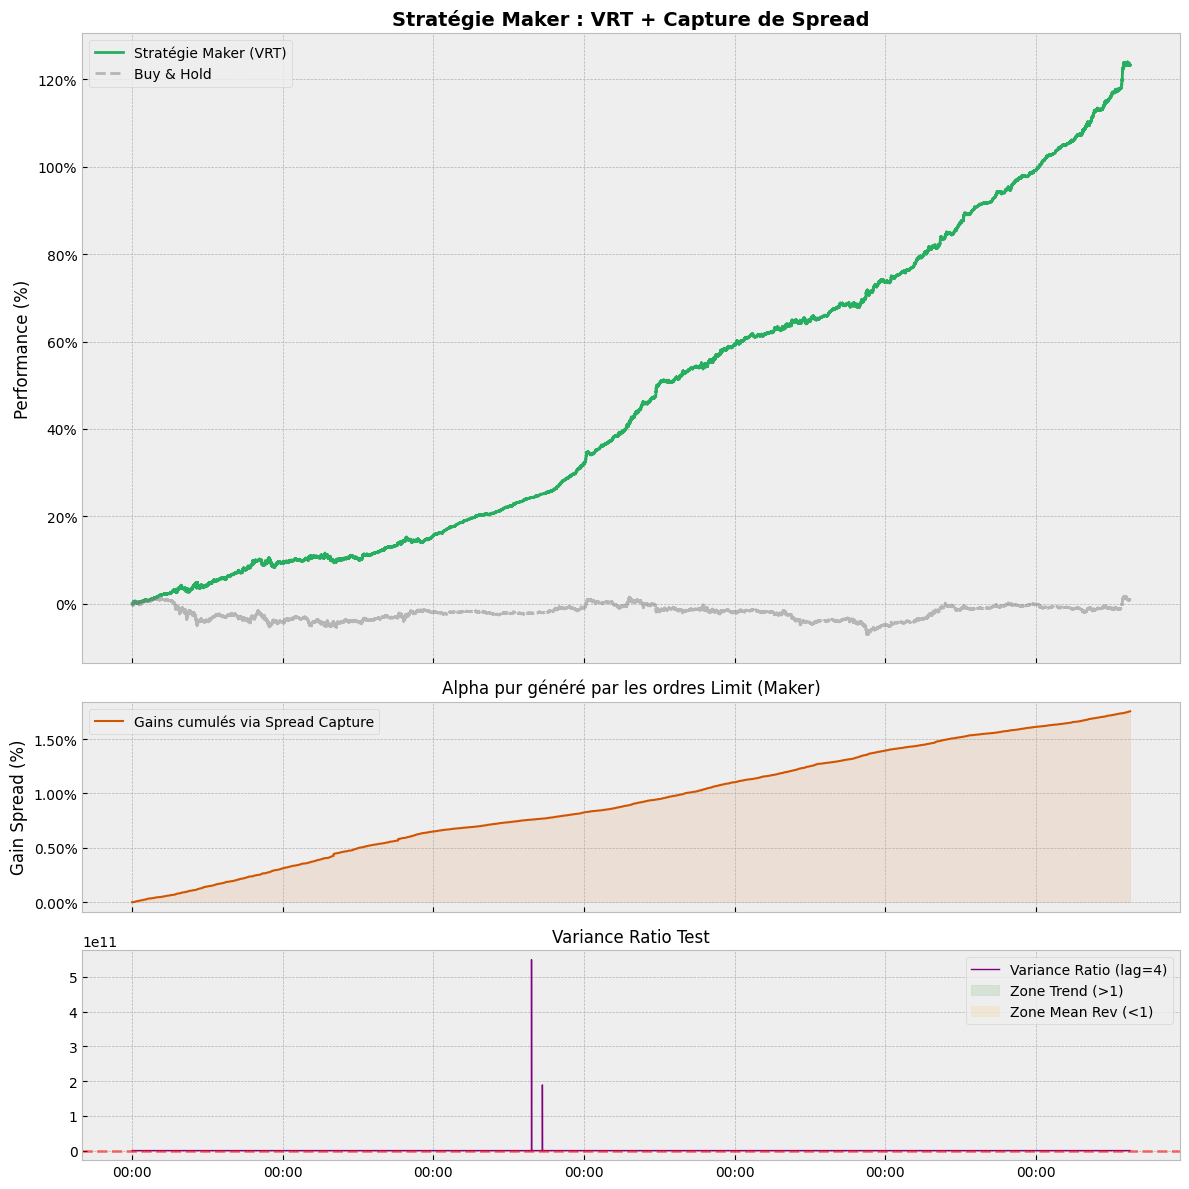

Performance Maker: 123.16%
Dont gains Spread: 1.75%


In [14]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick


# Paramètres globaux (alignés sur les conditions du hft.ipynb de base)
SLIPPAGE_BPS = 0.0      # pas de slippage explicite
EXEC_DELAY = 1          # exécution à la bougie suivante (shift 1 comme dans le code de base)
MAKER_FEE = -0.0000     # rebate nul (équiv. 0) comme dans le script initial
VRT_ENTRY = 1.0         # seuil VRT basique pour comparaison


def add_variance_ratio(df: pl.DataFrame, lag: int = 4, window: int = 120) -> pl.DataFrame:
    """
    Calcul du Variance Ratio Test:
    VR = Var(r_k) / (k * Var(r_1))
    VR < 1 : mean reversion ; VR > 1 : momentum.
    """
    return (
        df
        .with_columns(pl.col("close").log().alias("log_price"))
        .with_columns([
            pl.col("log_price").diff(1).alias("ret_1"),
            pl.col("log_price").diff(lag).alias("ret_lag")
        ])
        .with_columns([
            pl.col("ret_1").rolling_var(window_size=window).alias("var_1"),
            pl.col("ret_lag").rolling_var(window_size=window).alias("var_lag")
        ])
        .with_columns([
            (pl.col("var_lag") / (pl.col("var_1") * lag)).fill_null(1.0).alias("vrt")
        ])
        .drop(["log_price", "ret_1", "ret_lag", "var_1", "var_lag"])
    )


def run_maker_strategy(df_input, lag=4, window=120, maker_fee=MAKER_FEE, slippage_bps=SLIPPAGE_BPS, exec_delay=EXEC_DELAY):
    print("Calcul du VRT en cours... (maker)")
    df_with_vrt = add_variance_ratio(df_input, lag=lag, window=window)

    df_strategy = (
        df_with_vrt
        .with_columns([
                        pl.col("close").ewm_mean(span=50).alias("ema_trend")
        ])
        .with_columns([
            pl.when((pl.col("vrt") > VRT_ENTRY) & (pl.col("close") > pl.col("ema_trend")))
              .then(pl.lit(1))
              .when((pl.col("vrt") > VRT_ENTRY) & (pl.col("close") < pl.col("ema_trend")))
              .then(pl.lit(-1))
              .otherwise(pl.lit(0))
              .alias("signal")
        ])
    )

    df_pnl = (
        df_strategy
        .with_columns([
            pl.col("signal").shift(exec_delay).fill_null(0).alias("pos")
        ])
        .with_columns([
            (pl.col("pos") - pl.col("pos").shift(1).fill_null(0)).alias("trade_action")         
        ])
        .with_columns([
            pl.col("close").log().diff().fill_null(0).alias("market_ret_log"),  
            ((pl.col("ask_close") - pl.col("bid_close")) / 2 / pl.col("close")).alias("half_spread_pct")                        
        ])
        .with_columns([
            (pl.col("pos") * pl.col("market_ret_log")).alias("pnl_log_directional"),            
            # Capture de spread moins rebate maker et slippage (bps)                                              
            (pl.col("trade_action").abs() * (pl.col("half_spread_pct") - maker_fee - slippage_bps)).alias("spread_capture")                                                    
        ])
        .with_columns([
            (pl.col("pnl_log_directional") + pl.col("spread_capture")).cum_sum().alias("equity_curve_log"),                                                     
            pl.col("spread_capture").cum_sum().alias("cum_spread_captured")     
        ])
    )

    return df_pnl


if 'df_resampled_spread' in locals():
    df_maker_results = run_maker_strategy(df_resampled_spread)

    pdf_plot = df_maker_results.select([
        "datetime", "equity_curve_log", "market_ret_log", "cum_spread_captured", "trade_action", "vrt"
    ]).to_pandas()

    pdf_plot['strategy_pct'] = (np.exp(pdf_plot['equity_curve_log']) - 1) * 100
    pdf_plot['bnh_pct'] = (np.exp(pdf_plot['market_ret_log'].cumsum().fillna(0)) - 1) * 100
    pdf_plot['spread_gain_pct'] = (np.exp(pdf_plot['cum_spread_captured']) - 1) * 100

    plt.style.use('bmh')
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

    ax1.plot(pdf_plot['datetime'], pdf_plot['strategy_pct'], label='Stratégie Maker (VRT)', color='#27ae60', linewidth=2)
    ax1.plot(pdf_plot['datetime'], pdf_plot['bnh_pct'], label='Buy & Hold', color='gray', alpha=0.5, linestyle='--')
    ax1.set_title('Stratégie Maker : VRT + Capture de Spread', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Performance (%)')
    ax1.legend()
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax2.plot(pdf_plot['datetime'], pdf_plot['spread_gain_pct'], color='#d35400', label='Gains cumulés via Spread Capture', linewidth=1.5)
    ax2.fill_between(pdf_plot['datetime'], pdf_plot['spread_gain_pct'], 0, color='#d35400', alpha=0.1)
    ax2.set_title('Alpha pur généré par les ordres Limit (Maker)', fontsize=12)
    ax2.set_ylabel('Gain Spread (%)')
    ax2.legend()
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

    ax3.plot(pdf_plot['datetime'], pdf_plot['vrt'], color='purple', label='Variance Ratio (lag=4)', linewidth=1)
    ax3.axhline(1.0, color='red', linestyle='--', alpha=0.5)
    ax3.fill_between(pdf_plot['datetime'], pdf_plot['vrt'], 1.0, where=(pdf_plot['vrt'] > 1), color='green', alpha=0.1, label='Zone Trend (>1)')
    ax3.fill_between(pdf_plot['datetime'], pdf_plot['vrt'], 1.0, where=(pdf_plot['vrt'] < 1), color='orange', alpha=0.1, label='Zone Mean Rev (<1)')
    ax3.set_title('Variance Ratio Test', fontsize=12)
    ax3.legend()

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.tight_layout()
    plt.show()

    print(f"Performance Maker: {pdf_plot['strategy_pct'].iloc[-1]:.2f}%")
    print(f"Dont gains Spread: {pdf_plot['spread_gain_pct'].iloc[-1]:.2f}%")
else:
    print("Erreur: Le DataFrame 'df_resampled_spread' n'est pas défini. Veuillez charger les données d'abord.")

Spread bps stats (ask-bid)/mid:
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 229008.0 │
│ null_count ┆ 0.0      │
│ mean       ┆ 0.016393 │
│ std        ┆ 0.021002 │
│ min        ┆ 0.015502 │
│ 25%        ┆ 0.015951 │
│ 50%        ┆ 0.016098 │
│ 75%        ┆ 0.016355 │
│ max        ┆ 5.057572 │
└────────────┴──────────┘
VRT_ENTRY_SENS=1.0, FILTER_ENABLED=False, MAKER_FEE_REAL=0.0, EDGE_BUFFER_BPS=0.0
Meilleur slippage teste: 0.00 bps (perf 123.16%)
Slippage max pour rester >= 0% perf: 0.00 bps


,slippage_bps,perf_pct,spread_pct,bnh_pct,elig_pct,trades,mean_half_spread_bps
0,0.0,123.163282,1.754929,0.945766,100.0,21061.0,0.008196
1,1.0,-72.838414,-87.615233,0.945766,100.0,21061.0,0.008196
2,2.0,-96.694117,-98.492629,0.945766,100.0,21061.0,0.008196
3,3.0,-99.597635,-99.816535,0.945766,100.0,21061.0,0.008196
4,4.0,-99.951027,-99.977670,0.945766,100.0,21061.0,0.008196
5,5.0,-99.994039,-99.997282,0.945766,100.0,21061.0,0.008196
6,6.0,-99.999275,-99.999669,0.945766,100.0,21061.0,0.008196
7,7.0,-99.999912,-99.999960,0.945766,100.0,21061.0,0.008196
8,8.0,-99.999989,-99.999995,0.945766,100.0,21061.0,0.008196
9,9.0,-99.999999,-99.999999,0.945766,100.0,21061.0,0.008196


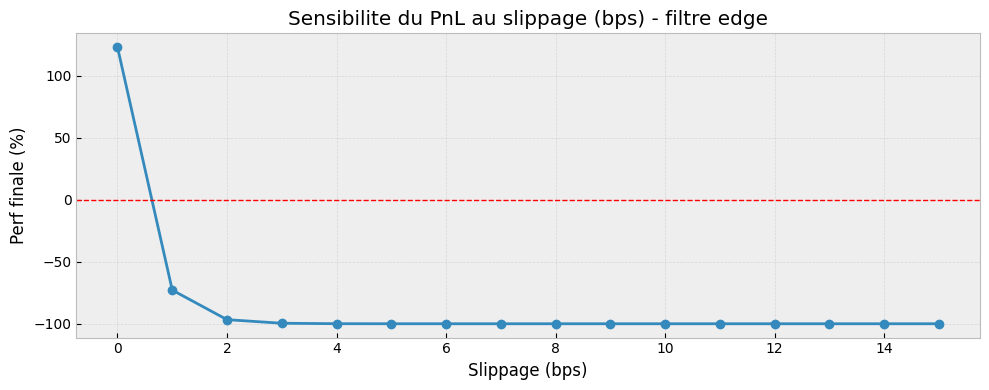

In [15]:
# Spread stats + slippage sweep with execution filter
import pandas as pd

# Renseigne ici tes fees reelles (positif = cout, negatif = rebate)
MAKER_FEE_REAL = 0.0      # mettre 0 ou rebate (negatif) si tu veux tout laisser passer
EDGE_BUFFER_BPS = 0.0     # marge supl. en bps pour couvrir file/inefficiencies
FILTER_ENABLED = False     # False = pas de filtre edge, True = applique half_spread > fee+buffer
SLIPPAGE_SWEEP = np.linspace(0.0, 0.0015, 16)  # 0 -> 15 bps
VRT_ENTRY_SENS = VRT_ENTRY
EXEC_DELAY_SENS = EXEC_DELAY


def print_spread_stats(df):
    spread_bps = ((df["ask_close"] - df["bid_close"]) / df["close"]) * 1e4
    stats = spread_bps.describe()
    print("Spread bps stats (ask-bid)/mid:")
    print(stats)


def run_maker_strategy_filtered(df_input, maker_fee=MAKER_FEE_REAL, lag=4, window=120, slippage_bps=0.0, exec_delay=EXEC_DELAY_SENS, edge_buffer_bps=EDGE_BUFFER_BPS):
    # edge_buffer_bps: cushion added on top of fees to avoid trading when edge est trop faible
    fee_cost = max(maker_fee, 0.0)
    min_edge = fee_cost + edge_buffer_bps  # on gate uniquement sur fee+buffer, pas sur le slippage

    df_with_vrt = add_variance_ratio(df_input, lag=lag, window=window)

    df_strategy = (
        df_with_vrt
        .with_columns([
            pl.col("close").ewm_mean(span=50).alias("ema_trend"),
            ((pl.col("ask_close") - pl.col("bid_close")) / 2 / pl.col("close")).alias("half_spread_pct")
        ])
        .with_columns([
            pl.when((pl.col("vrt") > VRT_ENTRY_SENS) & (pl.col("close") > pl.col("ema_trend")))
              .then(pl.lit(1))
              .when((pl.col("vrt") > VRT_ENTRY_SENS) & (pl.col("close") < pl.col("ema_trend")))
              .then(pl.lit(-1))
              .otherwise(pl.lit(0))
              .alias("signal")
        ])
    )

    df_exec = (
        df_strategy
        .with_columns([
            pl.when(pl.lit(FILTER_ENABLED))
              .then(pl.col("half_spread_pct") > min_edge)
              .otherwise(pl.lit(True))
              .alias("eligible"),
            pl.when(pl.lit(FILTER_ENABLED))
              .then(pl.when(pl.col("half_spread_pct") > min_edge).then(pl.col("signal")).otherwise(0))
              .otherwise(pl.col("signal"))
              .alias("signal_filtered")
        ])
        .with_columns([
            pl.col("signal_filtered").shift(exec_delay).fill_null(0).alias("pos")
        ])
        .with_columns([
            (pl.col("pos") - pl.col("pos").shift(1).fill_null(0)).alias("trade_action"),
            pl.col("close").log().diff().fill_null(0).alias("market_ret_log")
        ])
        .with_columns([
            (pl.col("pos") * pl.col("market_ret_log")).alias("pnl_log_directional"),
            (pl.col("trade_action").abs() * (pl.col("half_spread_pct") - maker_fee - slippage_bps)).alias("spread_capture")
        ])
        .with_columns([
            (pl.col("pnl_log_directional") + pl.col("spread_capture")).cum_sum().alias("equity_curve_log"),
            pl.col("spread_capture").cum_sum().alias("cum_spread_captured")
        ])
    )

    return df_exec


if 'df_resampled_spread' in locals():
    print_spread_stats(df_resampled_spread)
    print(f"VRT_ENTRY_SENS={VRT_ENTRY_SENS}, FILTER_ENABLED={FILTER_ENABLED}, MAKER_FEE_REAL={MAKER_FEE_REAL}, EDGE_BUFFER_BPS={EDGE_BUFFER_BPS}")

    records = []
    for slip in SLIPPAGE_SWEEP:
        df_tmp = run_maker_strategy_filtered(
            df_resampled_spread,
            maker_fee=MAKER_FEE_REAL,
            slippage_bps=slip,
            exec_delay=EXEC_DELAY_SENS,
            edge_buffer_bps=EDGE_BUFFER_BPS,
        )
        # Mesures d'activite pour comprendre si le filtre bloque tout
        act = df_tmp.select([
            pl.mean("eligible").alias("elig_pct"),
            pl.col("trade_action").abs().sum().alias("trades"),
            pl.mean("half_spread_pct").alias("mean_half_spread")
        ]).to_pandas().iloc[0]
        elig_pct = act["elig_pct"] * 100
        trades = act["trades"]

        pdf = df_tmp.select(["equity_curve_log", "cum_spread_captured", "market_ret_log"]).to_pandas()
        perf_pct = (np.exp(pdf["equity_curve_log"].iloc[-1]) - 1) * 100
        spread_pct = (np.exp(pdf["cum_spread_captured"].iloc[-1]) - 1) * 100
        bnh_pct = (np.exp(pdf["market_ret_log"].cumsum().iloc[-1]) - 1) * 100
        records.append({
            "slippage_bps": slip * 1e4,
            "perf_pct": perf_pct,
            "spread_pct": spread_pct,
            "bnh_pct": bnh_pct,
            "elig_pct": elig_pct,
            "trades": trades,
            "mean_half_spread_bps": act["mean_half_spread"] * 1e4,
        })

    df_slippage = pd.DataFrame(records)

    if df_slippage["trades"].max() == 0 or df_slippage["elig_pct"].max() == 0:
        print("Alerte: aucune bougie eligible/trade -> buffer/fees trop stricts (ou VRT trop eleve).")

    best_row = df_slippage.loc[df_slippage["perf_pct"].idxmax()]
    max_slip_positive = df_slippage.loc[df_slippage["perf_pct"] >= 0, "slippage_bps"].max()

    print(f"Meilleur slippage teste: {best_row['slippage_bps']:.2f} bps (perf {best_row['perf_pct']:.2f}%)")
    if pd.notna(max_slip_positive):
        print(f"Slippage max pour rester >= 0% perf: {max_slip_positive:.2f} bps")
    else:
        print("Aucune config testee ne reste >= 0% perf.")

    display(df_slippage.sort_values("slippage_bps"))

    plt.figure(figsize=(10, 4))
    plt.plot(df_slippage["slippage_bps"], df_slippage["perf_pct"], marker='o')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.title('Sensibilite du PnL au slippage (bps) - filtre edge')
    plt.xlabel('Slippage (bps)')
    plt.ylabel('Perf finale (%)')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
else:
    print("Erreur: 'df_resampled_spread' manquant : charge d'abord les donnees.")

Test de 5 x 6 = 30 configs...

Meilleure config: VRT=1.0, slip=0.00 bps -> perf=123.16%, trades=21061

5 configs avec perf >= 0%:


,vrt_entry,slippage_bps,perf_pct,spread_pct,bnh_pct,trades,mean_half_spread_bps
0,1.0,0.0,123.163282,1.754929,0.945766,21061.0,0.008196
6,1.1,0.0,103.372864,1.614361,0.945766,19727.0,0.008196
12,1.2,0.0,66.748248,1.387195,0.945766,16988.0,0.008196
18,1.3,0.0,44.341810,1.099339,0.945766,13520.0,0.008196
24,1.5,0.0,13.377969,0.556989,0.945766,6852.0,0.008196


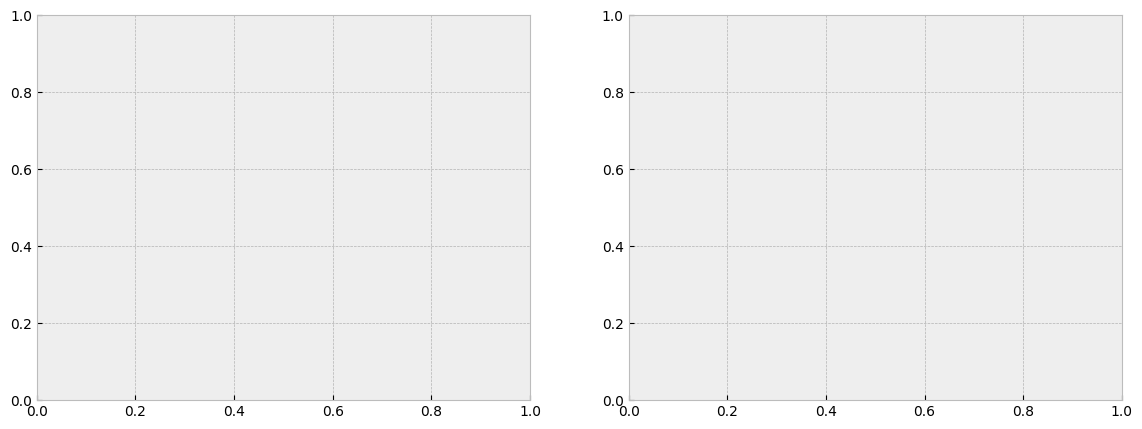

In [16]:
# Grid VRT_ENTRY vs Slippage pour trouver la config optimale
import itertools

VRT_ENTRY_GRID = [1.0, 1.1, 1.2, 1.3, 1.5]
SLIPPAGE_GRID = [0.0, 0.00005, 0.0001, 0.0002, 0.0005, 0.001]  # 0, 0.5, 1, 2, 5, 10 bps
MAKER_FEE_GRID = 0.0  # fee fixe pour le test
EXEC_DELAY_GRID = 1

print(f"Test de {len(VRT_ENTRY_GRID)} x {len(SLIPPAGE_GRID)} = {len(VRT_ENTRY_GRID)*len(SLIPPAGE_GRID)} configs...")

results_grid = []
if 'df_resampled_spread' in locals():
    for vrt_thr, slip in itertools.product(VRT_ENTRY_GRID, SLIPPAGE_GRID):
        df_test = run_maker_strategy_filtered(
            df_resampled_spread,
            maker_fee=MAKER_FEE_GRID,
            slippage_bps=slip,
            exec_delay=EXEC_DELAY_GRID,
            edge_buffer_bps=0.0,  # pas de filtre edge
        )
        
        # Override VRT_ENTRY dans la fonction inline (workaround)
        # On va plutôt recalculer le signal avec le bon seuil
        df_test_vrt = (
            df_test
            .with_columns([
                pl.when((pl.col("vrt") > vrt_thr) & (pl.col("close") > pl.col("ema_trend")))
                  .then(pl.lit(1))
                  .when((pl.col("vrt") > vrt_thr) & (pl.col("close") < pl.col("ema_trend")))
                  .then(pl.lit(-1))
                  .otherwise(pl.lit(0))
                  .alias("signal_new")
            ])
            .with_columns([
                pl.col("signal_new").shift(EXEC_DELAY_GRID).fill_null(0).alias("pos_new")
            ])
            .with_columns([
                (pl.col("pos_new") - pl.col("pos_new").shift(1).fill_null(0)).alias("trade_action_new"),
                pl.col("close").log().diff().fill_null(0).alias("market_ret_log_new")
            ])
            .with_columns([
                (pl.col("pos_new") * pl.col("market_ret_log_new")).alias("pnl_dir_new"),
                (pl.col("trade_action_new").abs() * (pl.col("half_spread_pct") - MAKER_FEE_GRID - slip)).alias("spread_cap_new")
            ])
            .with_columns([
                (pl.col("pnl_dir_new") + pl.col("spread_cap_new")).cum_sum().alias("equity_new"),
                pl.col("spread_cap_new").cum_sum().alias("cum_spread_new")
            ])
        )
        
        act = df_test_vrt.select([
            pl.col("trade_action_new").abs().sum().alias("trades"),
            pl.mean("half_spread_pct").alias("mean_half_spread")
        ]).to_pandas().iloc[0]
        
        pdf = df_test_vrt.select(["equity_new", "cum_spread_new", "market_ret_log_new"]).to_pandas()
        perf_pct = (np.exp(pdf["equity_new"].iloc[-1]) - 1) * 100
        spread_pct = (np.exp(pdf["cum_spread_new"].iloc[-1]) - 1) * 100
        bnh_pct = (np.exp(pdf["market_ret_log_new"].cumsum().iloc[-1]) - 1) * 100
        
        results_grid.append({
            "vrt_entry": vrt_thr,
            "slippage_bps": slip * 1e4,
            "perf_pct": perf_pct,
            "spread_pct": spread_pct,
            "bnh_pct": bnh_pct,
            "trades": act["trades"],
            "mean_half_spread_bps": act["mean_half_spread"] * 1e4,
        })
    
    df_grid_results = pd.DataFrame(results_grid)
    
    # Meilleure config
    best = df_grid_results.loc[df_grid_results["perf_pct"].idxmax()]
    print(f"\nMeilleure config: VRT={best['vrt_entry']}, slip={best['slippage_bps']:.2f} bps -> perf={best['perf_pct']:.2f}%, trades={best['trades']:.0f}")
    
    # Configs positives
    positive = df_grid_results[df_grid_results["perf_pct"] >= 0].sort_values("perf_pct", ascending=False)
    print(f"\n{len(positive)} configs avec perf >= 0%:")
    display(positive)
    
    # Heatmap perf vs VRT/slippage
    pivot = df_grid_results.pivot(index="vrt_entry", columns="slippage_bps", values="perf_pct")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))